Importing Necessary Libraries

In [1]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt

Merging CSV Files

In [2]:
# Load CSV files
movies = pd.read_csv('movies.csv')
label_encoder = LabelEncoder()
movies['genres'] = label_encoder.fit_transform(movies['genres'])

links = pd.read_csv('links.csv')

ratings = pd.read_csv('ratings.csv')    
tags = pd.read_csv('tags.csv')

# Merge movies with links
# movie_data = pd.merge(movies, links, on='movieId')

# Merge movie_data with ratings
movie_data = pd.merge(movies, ratings, on='movieId')

# Merge movie_data with tags
# full_data = pd.merge(movie_data, tags, on='movieId','userId')
full_data = pd.merge(movie_data, tags, on=['movieId', 'userId'])




In [3]:
full_data.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
0,1,Toy Story (1995),351,336,4.0,1122227329,pixar,1139045764
1,1,Toy Story (1995),351,474,4.0,978575760,pixar,1137206825
2,1,Toy Story (1995),351,567,3.5,1525286001,fun,1525286013
3,2,Jumanji (1995),417,62,4.0,1528843890,fantasy,1528843929
4,2,Jumanji (1995),417,62,4.0,1528843890,magic board game,1528843932


Checking for Nulls


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3476 entries, 0 to 3475
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      3476 non-null   int64  
 1   title        3476 non-null   object 
 2   genres       3476 non-null   int32  
 3   userId       3476 non-null   int64  
 4   rating       3476 non-null   float64
 5   timestamp_x  3476 non-null   int64  
 6   tag          3476 non-null   object 
 7   timestamp_y  3476 non-null   int64  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 230.8+ KB


Drop Irrelevant Columns

In [5]:
# full_data = full_data.drop(['timestamp_x', 'timestamp_y',"userId_x", "userId_y"], axis=1)
full_data = full_data.drop(['timestamp_x', 'timestamp_y'], axis=1)

Encoding Columns

In [6]:
full_data['genres'] = full_data['genres'].astype(str)

In [7]:
label_encoder = LabelEncoder()

full_data['genres'] = label_encoder.fit_transform(full_data['genres'])

full_data['tag'] = label_encoder.fit_transform(full_data['tag'])

full_data.tail(5)

,movieId,title,genres,userId,rating,tag
3471,187595,Solo: A Star Wars Story (2018),135,62,4.0,1392
3472,193565,Gintama: The Movie (2010),23,184,3.5,586
3473,193565,Gintama: The Movie (2010),23,184,3.5,746
3474,193565,Gintama: The Movie (2010),23,184,3.5,925
3475,193565,Gintama: The Movie (2010),23,184,3.5,1285


In [8]:
full_data=full_data[:1000]

Bayesian Network

In [9]:
full_data.tail(200)

,movieId,title,genres,userId,rating,tag
800,1212,"Third Man, The (1949)",337,474,4.0,524
801,1212,"Third Man, The (1949)",337,474,4.0,1540
802,1213,Goodfellas (1990),254,474,3.5,320
803,1214,Alien (1979),342,474,4.0,568
804,1217,Ran (1985),328,474,4.0,1311
...,...,...,...,...,...,...
995,1721,Titanic (1997),316,537,3.0,1301
996,1726,"Postman, The (1997)",363,125,4.5,297
997,1726,"Postman, The (1997)",363,125,4.5,408
998,1732,"Big Lebowski, The (1998)",206,474,3.5,111


In [10]:

model = BayesianNetwork([('genres', 'rating'), ('tag', 'rating'), ('rating', 'movieId'), ('userId', 'movieId')])

# Parameter Estimation using Maximum Likelihood Estimators
model.fit(full_data, estimator=MaximumLikelihoodEstimator)

# Perform inference
infer = VariableElimination(model)

query_result = infer.map_query(variables=['rating'], evidence={'userId': 62, 'genres': 114, 'tag': 110}, show_progress=False)
print(query_result)


{'rating': 1.0}


In [11]:
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
import pandas as pd

# Find movies unseen by the user (userId=62)
user_id = 20

unseen_movies = set(full_data['movieId'].unique()) - set(full_data[full_data['userId'] == user_id]['movieId'].unique())

# Create a DataFrame with all possible combinations of userId and unseen movies
user_unseen_combinations = [(user_id, movie_id) for movie_id in unseen_movies]
unseen_data = pd.DataFrame(user_unseen_combinations, columns=['userId', 'movieId'])

most_frequent_genre = full_data['genres'].mode().iloc[0]
most_frequent_tag = full_data['tag'].mode().iloc[0]

# Fill placeholder values in unseen data
unseen_data['genres'] = most_frequent_genre
unseen_data['tag'] = most_frequent_tag

# Create and fit the Bayesian Network
model = BayesianNetwork([('genres', 'rating'), ('tag', 'rating'), ('rating', 'movieId'), ('userId', 'movieId')])
model.fit(full_data, estimator=MaximumLikelihoodEstimator)

# Perform inference for each unseen movie
recommendations = []
infer = VariableElimination(model)
for index, row in unseen_data.iterrows():
    query_result = infer.map_query(variables=['rating'], evidence=row.to_dict(), show_progress=False)
    recommendations.append({'movieId': row['movieId'], 'predicted_rating': query_result['rating']})

# Sort recommendations by predicted rating in descending order
recommendations = sorted(recommendations, key=lambda x: x['predicted_rating'], reverse=True)

# Print or use the recommendations as needed, sorted by predicted rating in descending order
for recommendation in sorted(recommendations, key=lambda x: x['predicted_rating'], reverse=True):
    print(f"MovieID: {recommendation['movieId']}, Predicted Rating: {recommendation['predicted_rating']}")


MovieID: 750, Predicted Rating: 5.0
MovieID: 1, Predicted Rating: 1.0
MovieID: 2, Predicted Rating: 1.0
MovieID: 3, Predicted Rating: 1.0
MovieID: 1025, Predicted Rating: 1.0
MovieID: 5, Predicted Rating: 1.0
MovieID: 1028, Predicted Rating: 1.0
MovieID: 7, Predicted Rating: 1.0
MovieID: 1029, Predicted Rating: 1.0
MovieID: 1030, Predicted Rating: 1.0
MovieID: 1032, Predicted Rating: 1.0
MovieID: 11, Predicted Rating: 1.0
MovieID: 1033, Predicted Rating: 1.0
MovieID: 1035, Predicted Rating: 1.0
MovieID: 14, Predicted Rating: 1.0
MovieID: 16, Predicted Rating: 1.0
MovieID: 17, Predicted Rating: 1.0
MovieID: 1041, Predicted Rating: 1.0
MovieID: 1042, Predicted Rating: 1.0
MovieID: 21, Predicted Rating: 1.0
MovieID: 22, Predicted Rating: 1.0
MovieID: 25, Predicted Rating: 1.0
MovieID: 26, Predicted Rating: 1.0
MovieID: 28, Predicted Rating: 1.0
MovieID: 29, Predicted Rating: 1.0
MovieID: 31, Predicted Rating: 1.0
MovieID: 32, Predicted Rating: 1.0
MovieID: 34, Predicted Rating: 1.0
MovieI

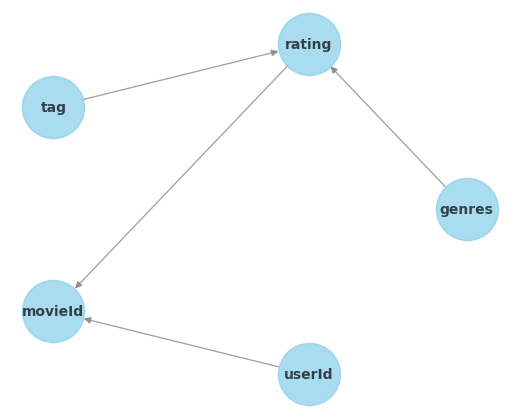

In [12]:

# Plot the Bayesian Network with adjusted parameters
pos = nx.circular_layout(model)  
plt.figure(figsize=(5, 4))  # Adjust the figure size as needed

# Draw nodes and edges
nx.draw(model, pos,with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", font_family="sans-serif", edge_color="gray", linewidths=1, alpha=0.7)

# Show the plot
plt.show()


Markov Model

In [13]:
# # Create a user-movie sequence dictionary
# user_movie_history = full_data.groupby('userId')['movieId'].apply(list).to_dict()

# # Build a Markov model based on user movie sequences
# def make_markov_model(movie_sequences):
#     markov_model = {}
#     for sequence in movie_sequences:
#         for i in range(len(sequence) - 1):
#             curr_movie, next_movie = sequence[i], sequence[i + 1]
#             if curr_movie not in markov_model:
#                 markov_model[curr_movie] = {}
#             if next_movie not in markov_model[curr_movie]:
#                 markov_model[curr_movie][next_movie] = 1
#             else:
#                 markov_model[curr_movie][next_movie] += 1

#     # Calculate transition probabilities
#     for curr_movie, transitions in markov_model.items():
#         total = sum(transitions.values())
#         for next_movie, count in transitions.items():
#             markov_model[curr_movie][next_movie] = count / total

#     return markov_model


In [14]:
# Create a user-genre sequence dictionary
user_genre_history = full_data.groupby('userId')['genres'].apply(list).to_dict()

# Build a Markov model based on user genre sequences
def make_markov_model(genre_sequences):
    markov_model = {}
    for sequence in genre_sequences:
        for i in range(len(sequence) - 1):
            curr_genre, next_genre = sequence[i], sequence[i + 1]
            if curr_genre not in markov_model:
                markov_model[curr_genre] = {}
            if next_genre not in markov_model[curr_genre]:
                markov_model[curr_genre][next_genre] = 1
            else:
                markov_model[curr_genre][next_genre] += 1

    # Calculate transition probabilities
    for curr_genre, transitions in markov_model.items():
        total = sum(transitions.values())
        for next_genre, count in transitions.items():
            markov_model[curr_genre][next_genre] = count / total

    return markov_model

# Usage
genre_markov_model = make_markov_model(list(user_genre_history.values()))


In [15]:
user_movie_sequences = list(user_genre_history.values())
markov_model = make_markov_model(user_movie_sequences)

In [16]:
# Generate movie recommendations for a user
def generate_movie_recommendation(markov_model, curr_genre, num_recommendations=10):
    recommendations = []
    for _ in range(num_recommendations):
        #print(f"Debug Point: Current Movie - {current_movie}")
        
        if curr_genre not in markov_model:
            print("Debug Point: Movie not in Markov model.")
            break  # Stop if there are no transitions for the current movie

        transitions = markov_model[curr_genre]
        #print(f"Debug Point: Transitions - {transitions}")

        if not transitions:  # Check if there are no transitions
            #print("Debug Point: No transitions for the current movie.")
            break

        next_movie = random.choice(list(transitions.keys()))
        recommendations.append(next_movie)
        #print(f"Debug Point: Next Movie - {next_movie}")

        current_movie = next_movie

    return recommendations

In [22]:
import random

# Example: Generate movie recommendations for user with ID 1
user_id_to_recommend = 336
user_history = user_genre_history.get(user_id_to_recommend, [])
#print(f"User History: {user_history}")

if len(user_history) > 1:  # Ensure that the user has a non-empty viewing history
    current_movie = random.choice(user_history[:-1])  # Start with a random movie from the user's history
    
    
    recommendations = generate_movie_recommendation(markov_model, current_movie)
    
    if recommendations:
        print(f"\nMovie Recommendations for User {user_id_to_recommend}:")
        for movie_id in recommendations:
            movie_title = full_data.loc[full_data['genres'] == movie_id, 'title'].values[0]
            print(f"{movie_title} (Movie ID: {movie_id})")
    else:
        print("\nNo recommendations generated.")
else:
    print(f"\nNo sufficient history found for User {user_id_to_recommend}.")




Movie Recommendations for User 336:
Three Musketeers, The (1993) (Movie ID: 236)
Jumanji (1995) (Movie ID: 125)
Jumanji (1995) (Movie ID: 125)
Three Musketeers, The (1993) (Movie ID: 236)
Bottle Rocket (1996) (Movie ID: 130)
Bottle Rocket (1996) (Movie ID: 130)
Three Musketeers, The (1993) (Movie ID: 236)
Jumanji (1995) (Movie ID: 125)
Bottle Rocket (1996) (Movie ID: 130)
Jumanji (1995) (Movie ID: 125)


In [ ]:
full_data.head(20)

,movieId,title,genres,userId,rating,tag
0,1,Toy Story (1995),95,336,4.0,1210
1,1,Toy Story (1995),95,474,4.0,1210
2,1,Toy Story (1995),95,567,3.5,909
3,2,Jumanji (1995),125,62,4.0,876
4,2,Jumanji (1995),125,62,4.0,1087
5,2,Jumanji (1995),125,62,4.0,432
6,2,Jumanji (1995),125,474,3.0,915
7,3,Grumpier Old Men (1995),248,289,2.5,1127
8,3,Grumpier Old Men (1995),248,289,2.5,1183
9,5,Father of the Bride Part II (1995),205,474,1.5,1234
